# <center> Анализ объявлений и построение прогнозной модели посещаемости 
<center> Автор: Михаил Усков

<center> На основе это проекта написана [статья](https://habrahabr.ru/post/280500/) на Хабре.

Для выполнения проекта была поставлена задача построить модель, которая могла бы по тексту объявления в интернете спрогнозировать посещаемость данного объявления. Для получения данных был разработан краулер, который скачивал объявления с сайта и формировал итоговый csv-файл. Тематика объявлений была одинакова для всех - передача собак из приютов и от частных лиц в добрые руки. 

## Загрузка библиотек

In [ ]:
%matplotlib inline

import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn

# кириллица на графиках
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

import matplotlib.pyplot as plt



from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', True)

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.learning_curve import validation_curve,learning_curve

from sklearn.base import TransformerMixin

from sklearn.feature_selection import SelectKBest, chi2



from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
import Stemmer

## Описание данных

В исходных данных содержится название, описание и общее число посещений объявления с начала публикации.

### Список переменных

1. description - полный текст объявления
+ identificator - номер объявления на сайте
+ num_counts - число посещений объявления с начала его размещения
+ price - цена, за которую предлагается купить животное. обычно, волонтеры ставят 100р. или вовсе не указывают цену.
+ start_date - дата, когда объявление было размещено
+ title - название объявления, как оно выглядит на первой странице.

In [2]:
dataset = pd.read_csv('../../data/billdoard_dataset.csv', header = 0)

In [3]:
dataset.head()

,description,identificator,num_counts,price,start_date,title
0,Маечка небольшая ласковая девочка. Красивая и ...,101330173,2066,Неуказана,24 сентября 2012,Удивительный метис лайки Маечка ищет семью (в ...
1,"Зося – милая, совсем простая собака. Не может ...",101766363,810,Неуказана,26 сентября 2012,"Зося-просто скромная собака, верная подруга. В..."
2,"Реми застенчивая девчушка, никак не может прив...",104275455,928,Неуказана,7 октября 2012,Скромная застенчивая Реми в добрые руки в дар
3,кане корсо для вязки Дата рождения 04.03.2008 ...,10636944,4358,Неуказана,6 сентября 2010,"Кане Корсо, Кобель, вязка"
4,"Жизнерадостная, энергичная, очень самоуверенна...",106432433,1567,Неуказана,16 октября 2012,"Обаятельнейшая, энергичная, самоуверенная Рада"


### Описательные статистики

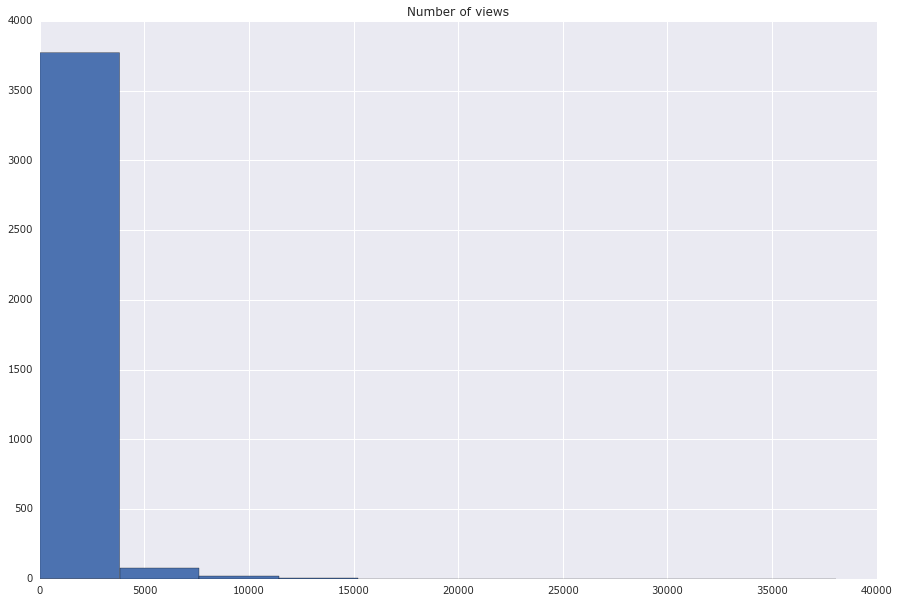

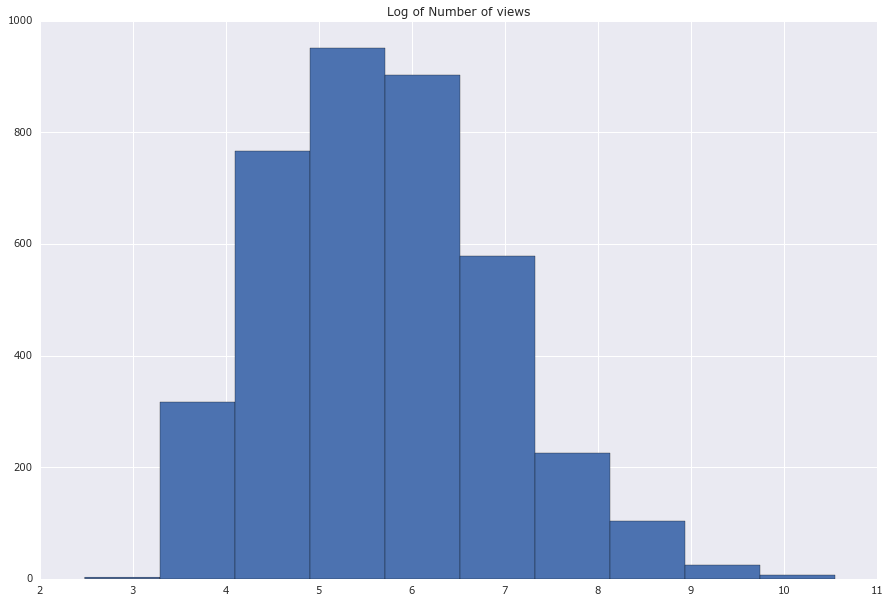

In [4]:
# посещаемость
dataset['num_counts'].hist()
plt.title('Number of views')
plt.show()

# логарифм посещаемости
dataset['num_counts'].apply(np.log).hist()
plt.title('Log of Number of views')
plt.show()

In [5]:
# цена
print(pd.value_counts(dataset['price']).head(20))

Неуказана     2566
100            486
Договорная     115
50              73
500             67
30000           48
50000           47
40000           41
60000           40
35000           36
25000           35
20000           30
1000            27
15000           24
10000           23
45000           19
300             19
200             19
5000            11
65000           10
Name: price, dtype: int64


Число слов в объявлении:

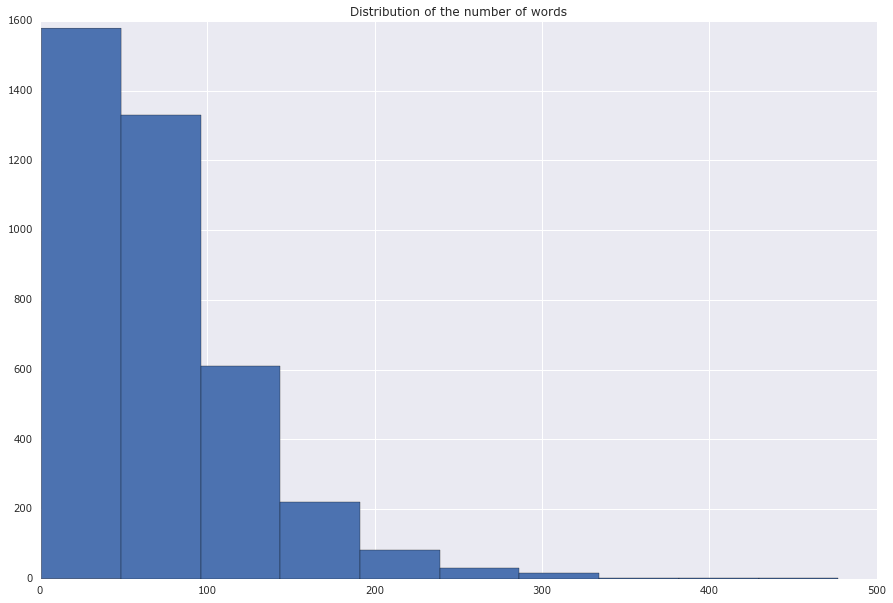

In [6]:
num_of_words = dataset['description'].apply(lambda x: len(x.split(' ')))
plt.hist(num_of_words)
plt.title('Distribution of the number of words')

Диаграммы рассеяния будут построены после предобработки

## Предобработка

1. Признаками будут являться отдельные слова или биграммы, поэтому их необходимо нормализовать, чтобы одно и то же слово, но в разных формах не считалось как два разных. Эта операция называется стемминг, что согласно вики значит процесс нахождения основы слова для заданного исходного слова. 
2. Поле "date" содержит дату в форме строки, поэтому ее нужно перевести в правильный формат
3. В качестве признака берется поле "description", поэтому текст необходимо перевести в представление "bag of words" и применить tf-idf. При этом из текста убираются предлоги, вспомогательные частицы и т.д. Эти слова называются stopwords.
4. Поскольку каждое объявление имеет свою дату публикации, то целевая переменная здесь представляет не просто число просмотров, а число просмотров, разделенное на число дней с момента подачи до скачивания их моим краулером. Т.е. можно считать, что это грубая оценка числа посетителей в сутки.
5. После нескольких неудачных попыток восстановить регрессию между document-term matrix и средним числом посетителей, было принято решение разбить целевую переменную на интервалы(квартили) и рассматривать задачу классификации (отсюда и tf-idf). Т.е. на выходе модель будет прогнозировать интервал, где содержится средняя посещаемость для данного объявления. Преобразование в квартили производилось только на обучающей выборке, поэтоу необходимо написать функцию, которая преобразовает и тестовую. Преобразовывать всю выборку целиком нельзя, посольку тогда тестовые данные будут косвенно участвовать в обучении.
6. Поле 'price' представляет собой цену за животное. Большие цены являются индикатором продажи породистого животного, нас же интересует некоммерческая деятельность, поэтому оставляем только те записи, для которых price < 500р.
7. Разбиение на train\test. Причем на train будет проводится обучение и подбор параметров по сетке на кросс-валидации, а на test будет проверяться финальное качество. Основная метрика - accuracy

In [ ]:
# стемминг
stop = stopwords.words('russian')
stemobject = Stemmer.Stemmer('russian')#RussianStemmer()
def stemmer(x):
    stem_function = stemobject.stemWord
    out = [stem_function(word) for word in x.split(' ')]
    return ' '.join(out)

# преобразование тестовых данных в квартили
def y_transform(x):
    
    if isinstance(x,str):
        return x
    
    categories = y_train.unique().categories.get_values()
    
    first = categories[0]
    first = first.replace('[','').replace(']','').split(',')
    first = [float(i) for i in first]

    last = categories[-1]
    last = last.replace('(','').replace(']','').split(',')
    last = [float(i) for i in last]
    
    if (x < first[0]):
        return categories[0] 
        
    if (x >= first[0]) & (x <= first[1]):
        return categories[0]
    
    if (x >= last[0]) & (x <= last[1]):
        return categories[-1] 
    
    if (x >= last[1]):
        return categories[-1]  
        
    for cat in categories[1:-1]:
        c = cat.replace('(','').replace(']','').split(',')
        c = [float(i) for i in c]
        if (x > c[0]) & (x <= c[1]):
            return cat
        
# обработка даты
month = ['января','февраля','марта','апреля','мая','июня','июля','августа','сентября','октября','ноября','декабря']
order = {M: i+1 for i,M in enumerate(month)}

def date_helper(x):
    now = datetime.datetime(2016,3,18)
    x = x.split(' ')
    d = x[0]
    m = order[x[1]]
    y = x[2]
    
    dateobject =  datetime.datetime(int(y),int(m),int(d))
    delta = now-dateobject
    return delta.days

In [8]:
# идентификатор не несет полезной нагрузки
dataset.drop(['identificator'], axis = 1, inplace = True)

In [9]:
dataset['num_days'] = dataset['start_date'].apply(date_helper)
dataset.drop(['start_date'], axis = 1, inplace = True)

Создание новой целевой переменной как отношения общего числа посещений к числу дней, прошедших с момента публикации до момента попадания объявления в выборку. В знаменателе добавляет единичка, чтобы избежать деления на нуль.

In [10]:
dataset['mean_count'] = dataset['num_counts'] / (dataset['num_days']+1)
dataset.drop(['num_counts'], axis = 1, inplace = True)
dataset.drop(['num_days'], axis = 1, inplace = True)

In [11]:
dataset.describe()

,mean_count
count,3879.000000
mean,12.932416
std,27.590200
min,0.088768
25%,1.639117
50%,4.491228
75%,12.714286
max,613.000000


Ниже на графике видно, что чем меньше слов в объявлении, тем больше просмотров, если оценивать грубо. Предполагаю, что это справедливо только для объявлений данной конкретной тематики, поскольку чем больше слов, тем скорее всего сложнее история у животного.

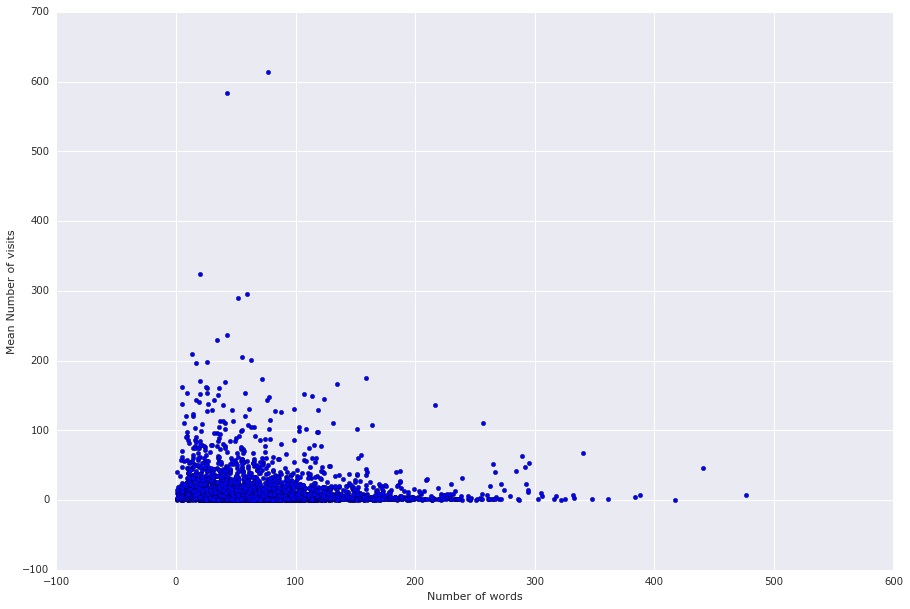

In [12]:
plt.scatter(num_of_words,dataset['mean_count'])
plt.xlabel('Number of words')
plt.ylabel('Mean Number of visits')

Рассмотрим те объявления, которые составляют топ-20 по среднему числу посещений:

In [13]:
sorted_df = dataset.sort(['mean_count'], ascending=False)
for i in (sorted_df.index.tolist()[:10]):
    print('==================')
    print('\nНазвание: ')
    print('----------')
    print(sorted_df.loc[i,'title'])
    
    print('\nОписание: ')
    print('----------')
    print(sorted_df.loc[i,'description'])

    
    print('\nСреднее число просмотров: ',sorted_df.loc[i,'mean_count'])
    print('--------------------------')
    


Название: 
----------
Щенки ищут заботливых хозяев

Описание: 
----------
Подарите себе радость – приобретите верного друга! За символическую плату отдадим в хорошие добрые руки щенка породистых собак с отличными родословными. Папа- неоднократный призер выставок, бернский зенненхунд, красавец и умница. Мама – черный русский терьер, прекрасная охранница, послушное, ласковое и верное существо! Щенки родились 16 января 2016 г. Уже умеют самостоятельно есть, исполняют некоторые команды ( например команду «ко мне»).  Пока есть  и девочки и мальчики. Щенки очень забавные, подвижные, веселые, с прекрасным аппетитом. Привиты.

Среднее число просмотров:  613.0
--------------------------

Название: 
----------
Щенок вельш корги пемброк

Описание: 
----------
Продается очаровательный мальчик вельш корги пемброк, рыжий, натуральный бобтейл от чистокровных родителей. У щенка неправильный прикус, вследствие чего он не может выставляться на выставках и участвовать в племенном разведении. Ищет заботл

Видно, что наибольшей популярностью пользуются попродистые собаки. Теперь рассмотрим наименее популярные объявления:

In [14]:
sorted_df = dataset.sort(['mean_count'], ascending=True)
for i in (sorted_df.index.tolist()[:10]):
    print('==================')
    print('\nНазвание: ')
    print('----------')
    print(sorted_df.loc[i,'title'])
    
    print('\nОписание: ')
    print('----------')
    print(sorted_df.loc[i,'description'])

    
    print('\nСреднее число просмотров: ',sorted_df.loc[i,'mean_count'])
    print('--------------------------')


Название: 
----------
Метис дога Блек

Описание: 
----------
Самый очаровательный пес во вселенной ждет свою семью!  Возраст полтора года, рост в холке более 55 см. Очень веселый и жизнерадостный, ориентирован на человека. При прогулке проблем не возникает, к поводку приучен. Хорошо ладит с другими собаками. Блэк очень осторожен и умен. Такому общительному и молодому псу в приюте очень тоскливо, и каждый приход волонтера для него настоящий праздник! Хочется, чтобы наш замечательный Блэк  обрел своего настоящего друга!

Среднее число просмотров:  0.088768115942
--------------------------

Название: 
----------
Милаха Лили ищет дом

Описание: 
----------
Лили Добрая, очень ласковая, умная девочка. Возраст - 2,5 года. К другим собакам относится доброжелательно, очень тонко чувствует настроение человека и его отношение к себе. К поводку приучена, на прогулках всегда идет рядом. Когда смотришь в глаза Лили, понимаешь насколько она хочет тепла и настоящей заботы. Она, как и все здесь, ищет 

К сожалению, животные из приютов пользуются меньшей популярностью.

(array([   5.,  122.,  612.,  835.,  884.,  733.,  432.,  193.,   58.,    5.]),
 array([-2.42172775, -1.53771848, -0.65370921,  0.23030006,  1.11430933,
         1.99831859,  2.88232786,  3.76633713,  4.6503464 ,  5.53435567,
         6.41836494]),
 <a list of 10 Patch objects>)

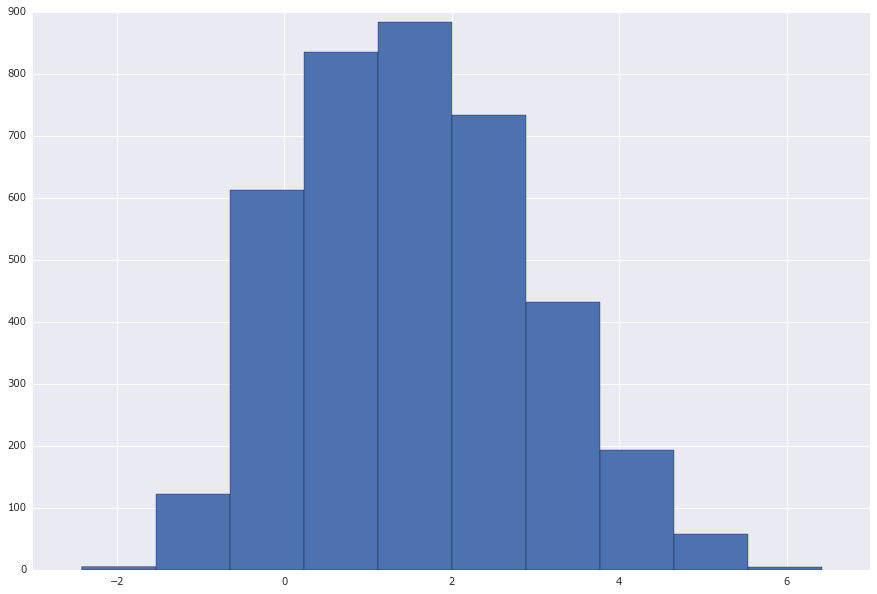

In [15]:
plt.hist(np.log(dataset['mean_count']))

In [16]:
# если цена указанна как 'Неуказана', 'Договорная' то она заменяется на 100р.
dataset['price'] = dataset['price'].apply(lambda x: 100 if x in ['Неуказана', 'Договорная'] else int(x))
dataset = dataset[dataset['price'] <= 500]
dataset.drop(['price'], axis = 1, inplace = True)
dataset.shape

(3384, 3)

Стемминг можно применить ко всему набору сразу, поскольку для работы он использует только данное конкретное слово

In [17]:
dataset['description'] = dataset['description'].apply(stemmer) 

In [18]:
X_train, X_test, y_train, y_test  = train_test_split(dataset['description'],dataset['mean_count'], test_size=0.33)

Разбиение целевой переменной на 5 квартилей. Т.е. получили задачу многоклассовой классификации из 5 классов

In [19]:
y_train = pd.qcut(y_train, q= 5)

Рассмотрим baseline - qcut разбил выборку равномерно - по 454 объекта в каждом квартиле. Если всем объектам приписать какой-нибудь один класс, то качество будет 20%.

In [20]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_train))
print('Baseline accuracy: ',454/y_train.shape[0])

(13.599, 324]      454
[0.0888, 1.184]    454
(5.334, 13.599]    453
(2.436, 5.334]     453
(1.184, 2.436]     453
dtype: int64
(13.599, 324]      454
[0.0888, 1.184]    454
(5.334, 13.599]    453
(2.436, 5.334]     453
(1.184, 2.436]     453
dtype: int64
Baseline accuracy:  0.20026466696074108


Сетка для поиска гиперпараметров.Поскольку интересно знать, какие слова влияют на посещаеомсть, было решенно не использовать LSA

In [21]:
parameters = {
    'vect__max_df': (0.5, 0.75,1),
    #'vect__max_features': (10000, 50000),
    #'vect__ngram_range': ((1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True,False),
    #'tfidf__norm': ('l2'),
    #'svd__n_components':(50,100,1000),
    "clf__max_depth": [3, None],
    "clf__max_features": [1, 3, 10],
    "clf__min_samples_split": [1, 3, 10],
    "clf__min_samples_leaf": [1, 3, 10],
    "clf__bootstrap": [True, False]
}

total_comb = 1
for i in parameters.values():
    total_comb *= len(i)
print('Всего комбинаций: ', total_comb)

Всего комбинаций:  324


В качестве классификатора - случайный лес.

In [22]:
pipe = Pipeline([('vect', CountVectorizer(stop_words=stop, ngram_range=(1, 2), max_features=10000)),
                 ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
                 #('svd', TruncatedSVD(algorithm='randomized')),
                 ('clf', RandomForestClassifier(n_estimators=500, verbose = False))]) 


grid_search = GridSearchCV(pipe, parameters, verbose=True, n_jobs = -1, cv = 5)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 11.5min finished


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.386
Best parameters set:
	clf__bootstrap: False
	clf__max_depth: None
	clf__max_features: 3
	clf__min_samples_leaf: 3
	clf__min_samples_split: 1
	vect__max_df: 0.5


In [23]:
# Преобразование тестовой выборки в квартили
y_test = y_test.apply(y_transform)

In [24]:
print(classification_report(y_test,grid_search.predict(X_test)))

             precision    recall  f1-score   support

(1.184, 2.436]       0.30      0.19      0.24       206
(13.599, 324]       0.37      0.58      0.45       222
(2.436, 5.334]       0.21      0.10      0.13       234
(5.334, 13.599]       0.38      0.27      0.31       241
[0.0888, 1.184]       0.44      0.72      0.54       214

avg / total       0.34      0.37      0.33      1117



In [25]:
print(pd.crosstab(y_test,grid_search.predict(X_test)))

col_0            (1.184, 2.436]  (13.599, 324]  (2.436, 5.334]  (5.334, 13.599]  [0.0888, 1.184]
mean_count                                                                                      
(1.184, 2.436]               40             21              24               21              100
(13.599, 324]                14            129              23               37               19
(2.436, 5.334]               33             80              23               39               59
(5.334, 13.599]              19            111              24               64               23
[0.0888, 1.184]              28             12              13                6              155


Топ-10 слов, которые сильнее всего влияют на классификацию

In [26]:
feature_weights = {'name': grid_search.best_estimator_.named_steps['vect'].get_feature_names(),
                  'weight': grid_search.best_estimator_.named_steps['clf'].feature_importances_}

feature_weights = pd.DataFrame(data=feature_weights['weight'], index = feature_weights['name'], columns = ['weight'])
feature_weights.sort(['weight'], ascending=False, inplace=True)
feature_weights.head(10)

,weight
лет,0.005378
см,0.005045
собак,0.004336
стерилизована,0.003811
люб,0.003482
окол,0.003441
см холке,0.003116
холк окол,0.002992
поводке,0.002915
приюте,0.002730


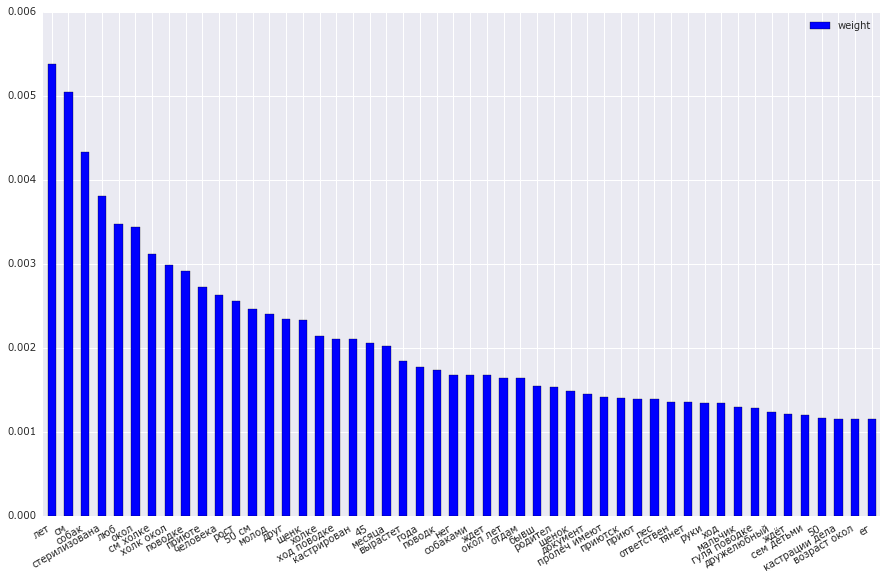

In [27]:
fig, ax = plt.subplots()
feature_weights.head(50).plot(ax=ax,kind = 'bar')
fig.autofmt_xdate()

## Диаграммы рассеяния(scatterplots)

Вообще, этот этап должен быть в начале исследования, но поскольку у нас текст и сильно разреженная матрица объекты-признаки, то имеет смысл построить графики только для топ-7, в соответствии с информацией о важности признаков, полученной от случайного леса.

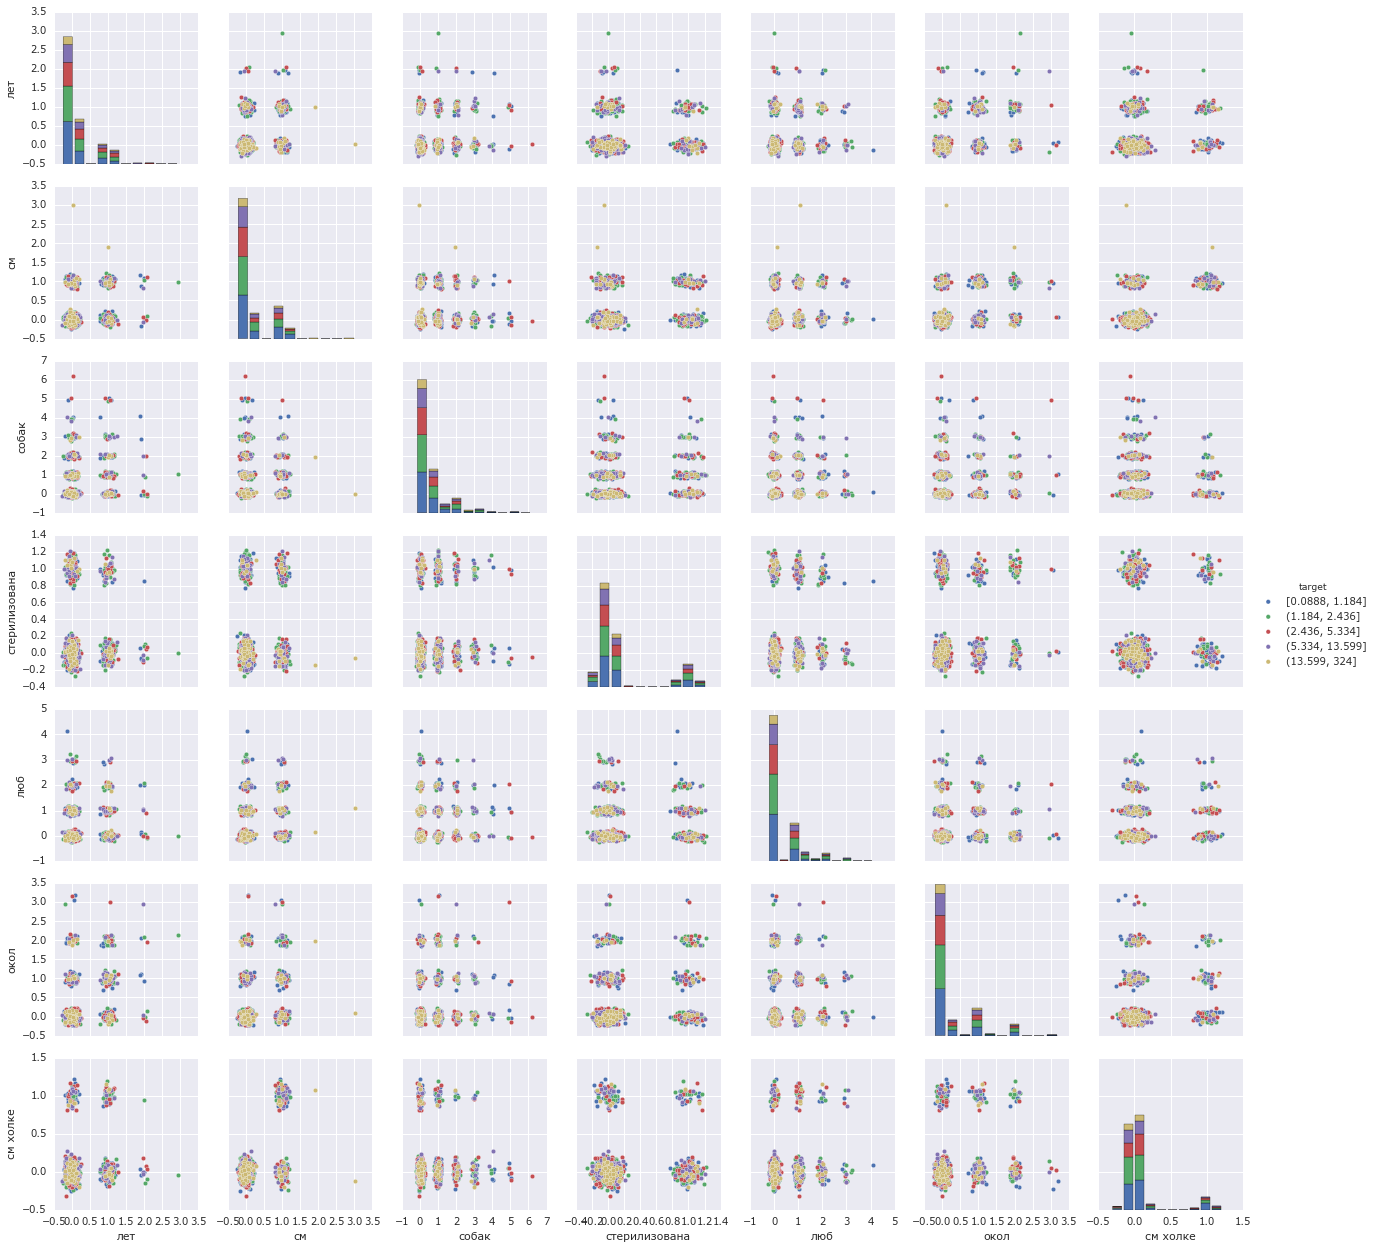

In [28]:
from sklearn.preprocessing import LabelEncoder

dataset_tfidf = pd.DataFrame(grid_search.best_estimator_.named_steps['vect'].transform(X_train).toarray())
dataset_tfidf.columns = grid_search.best_estimator_.named_steps['vect'].get_feature_names()
dataset_tfidf = dataset_tfidf[feature_weights.index.tolist()[:7]]

# поскольку у нас дискретные отсчеты, немного "размоем" значения, чтобы точки не ложились одна на другую:
for k in dataset_tfidf.keys():
    dataset_tfidf[k] = dataset_tfidf[k].apply(lambda x: int(x)+np.random.normal(0,0.08))

dataset_tfidf['target'] =(y_train)

seaborn.pairplot(dataset_tfidf, hue = 'target')


Видно, что желтые точки(интервал с максимальным числом просмотров) хорошо различаются от остальных

## Кривые обучения

In [29]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring, n_jobs = -1)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

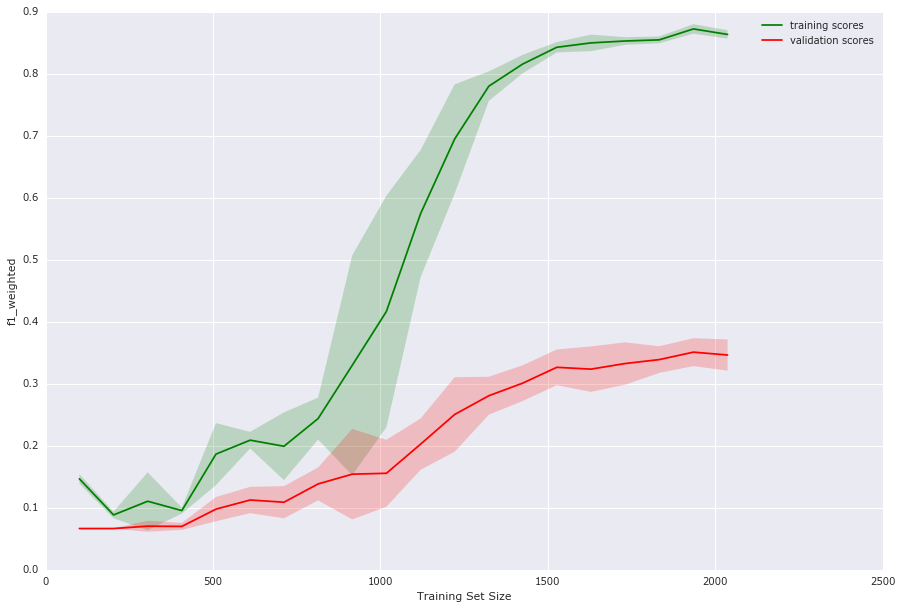

In [30]:
plot_learning_curve(grid_search.best_estimator_,X_train, y_train, scoring='f1_weighted', cv=10)

**Примечание:** иногда при разных запусках на валидационной кривой можно увидеть, что классификатор всегда отлично описывает обучающую выборку, но зазор между train и cv кривыми довльно большой. Скорее всего это индикатор переобучения и вот откуда оно взялось: в качестве классификатора передается pipeline, **гиперпараметры** которого были настроены ранее по той же обучающей выборке. Т.е. learning_curve конечно проводит обучение заново, но только для параметров случайного леса, а гиперпараметры остаются прежними. По хорошему, необходимо в learning_curve передать объект grid_search и для каждого размера обучающей выборки производить поиск по сетке, но это будет слишком долго для данной учебной задачи.

## Выводы

1. Построена модель прогнозирования среднего числа посещений объявления с качеством accuracy = 0.386, что почти в два раза больше, чем прогнозирование константным значением (accuracy = 0.20)
2. Точнее всего модель предсказывает значения, которые находятся в крайних интервалах - [0.0888, 1.222] и (13.193, 324] 
3. Судя по значимости слов, люди обращают внимание на пол, возраст, медицинские и физиологические характеристики, умение гулять на поводке
4. Качество модели может быть улучшено, если к тексту добавить фотографии. Для извлечения признаков из фото можно попробовать использовать сверточные нейронные сети, например, AlexNet

## Сылки


1. [Text classification for russian language][1]
+ [Russian stemming algorithm][2]
+ [nltk.stem.snowball.RussianStemmer][3]
+ [Classification of text documents using sparse features][4]


[1]: http://stackoverflow.com/questions/18011756/text-classification-for-russian-language
[2]: http://snowball.tartarus.org/algorithms/russian/stemmer.html
[3]: http://www.nltk.org/api/nltk.stem.html
[4]: http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html